<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/malitha/task2_eda_and_data_preprocessing_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 Notebook for "XGBoost"


## Imports and Setup

**Import the Libararies**


In [31]:
# !pip install tensorflow pandas numpy matplotlib scikit-learn

In [78]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
warnings.filterwarnings('ignore')

### Connecting to Google Drive

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading data set files

In [34]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/bookings_train.csv')
tasks_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/tasks.csv')
staffing_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/staffing_train.csv')

## EDA



### EDA of Staffing data

lets take a look at the columns and some of their values

In [35]:
staffing_data.head()

,date,section_id,employees_on_duty,total_task_time_minutes
0,2021-01-01,SEC-001,1,834.569483
1,2021-01-01,SEC-002,4,1525.368990
2,2021-01-01,SEC-003,2,662.095279
3,2021-01-01,SEC-004,4,1499.112620
4,2021-01-01,SEC-005,3,1238.533073


In [36]:
staffing_data.describe()

,employees_on_duty,total_task_time_minutes
count,5802.000000,5802.000000
mean,4.458807,1662.296769
std,2.794417,1147.134643
min,1.000000,91.109596
25%,3.000000,859.104314
50%,4.000000,1358.176924
75%,6.000000,2123.936358
max,26.000000,10658.173092


removing unnecessary columns. We wont need the total_task_time_minutes because this data wont be provided as input from the test datasets. We need the date and section_id  because they will be to calculate the actual target value (the thing to be predicted) for task 2.

In [37]:
staffing_data = staffing_data.drop(['total_task_time_minutes'],axis=1)

now lets look at the new table headers again.


In [38]:
staffing_data.head()

,date,section_id,employees_on_duty
0,2021-01-01,SEC-001,1
1,2021-01-01,SEC-002,4
2,2021-01-01,SEC-003,2
3,2021-01-01,SEC-004,4
4,2021-01-01,SEC-005,3


lets get a better idea of how null values have been distributed amoung the columns

In [39]:
staffing_data.isna().sum()

,0
date,0
section_id,0
employees_on_duty,0


### EDA of Bookings data

In [40]:
bookings_data.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3


In [41]:
bookings_data.describe()

,citizen_id,num_documents,queue_number,satisfaction_rating
count,2.036930e+05,203693.000000,203693.000000,203693.000000
mean,4.996145e+09,2.436790,9.310511,4.187277
std,2.880985e+09,1.734511,8.245711,0.463539
min,4.318100e+04,0.000000,1.000000,3.000000
25%,2.504323e+09,1.000000,3.000000,4.000000
50%,4.995536e+09,2.000000,7.000000,4.000000
75%,7.491514e+09,3.000000,13.000000,4.000000
max,9.999975e+09,14.000000,133.000000,5.000000


In [51]:
bookings_data.isna().sum()

,0
booking_id,0
citizen_id,0
booking_date,0
appointment_date,0
appointment_time,0
check_in_time,6092
check_out_time,6092
task_id,0
num_documents,0
queue_number,0


### EDA of tasks data

In [48]:
tasks_data.head()

,task_id,task_name,section_id,section_name
0,TASK-001,Register new motor vehicles and issue registra...,SEC-001,Vehicle Registration
1,TASK-002,Process the transfer of vehicle ownership.,SEC-001,Vehicle Registration
2,TASK-003,Conduct theoretical and practical examinations...,SEC-002,Driver Licensing
3,TASK-004,Process the renewal and reissue of driving lic...,SEC-002,Driver Licensing
4,TASK-005,Issue international driving permits.,SEC-002,Driver Licensing


In [50]:
tasks_data.describe()

,task_id,task_name,section_id,section_name
count,19,19,19,19
unique,19,19,6,6
top,TASK-001,Register new motor vehicles and issue registra...,SEC-002,Driver Licensing
freq,1,1,4,4


In [49]:
tasks_data.isna().sum()

,0
task_id,0
task_name,0
section_id,0
section_name,0


# Merge Datasets

In [75]:
df_bookings_merged = pd.merge(bookings_data, tasks_data, on='task_id', how='left')
df_bookings_merged['appointment_date'] = pd.to_datetime(df_bookings_merged['appointment_date'])
df_workload = df_bookings_merged.groupby(
    [df_bookings_merged['appointment_date'].dt.date, 'section_id']
).agg(
    total_appointments=('booking_id', 'count'),
    total_documents=('num_documents', 'sum')
).reset_index()
df_workload = df_workload.rename(columns={'appointment_date': 'date'})

staffing_data['date'] = pd.to_datetime(staffing_data['date'])
df_workload['date'] = pd.to_datetime(df_workload['date'])
training_df = pd.merge(staffing_data, df_workload, on=['date', 'section_id'], how='left')

training_df['total_appointments'] = training_df['total_appointments'].fillna(0)
training_df['total_documents'] = training_df['total_documents'].fillna(0)

In [76]:
print(f"\nShape of the training data: {training_df.shape}")
print("\nMissing values check:")
training_df.isnull().sum()


Shape of the training data: (5802, 5)

Missing values check:


,0
date,0
section_id,0
employees_on_duty,0
total_appointments,0
total_documents,0


# Feature Engineering

In [77]:
def create_time_features(df):
    """Creates time-series features from a datetime column."""
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
    return df

training_df = create_time_features(training_df)

# Handle Categorical Features (One-Hot Encoding)
if 'section_id' in training_df.columns:
    # MODIFIED LINE: Added dtype=int to ensure the new columns are 1s and 0s
    training_df = pd.get_dummies(training_df, columns=['section_id'], prefix='section', dtype=int)

print("✅ Data preparation and feature engineering complete.")
print("\nPreview of the final training data:")
training_df.head()

✅ Data preparation and feature engineering complete.

Preview of the final training data:


,date,employees_on_duty,total_appointments,total_documents,day_of_week,month,year,quarter,day_of_year,day_of_month,week_of_year,is_weekend,section_SEC-001,section_SEC-002,section_SEC-003,section_SEC-004,section_SEC-005,section_SEC-006
0,2021-01-01,1,13,18,4,1,2021,1,1,1,53,0,1,0,0,0,0,0
1,2021-01-01,4,35,106,4,1,2021,1,1,1,53,0,0,1,0,0,0,0
2,2021-01-01,2,21,51,4,1,2021,1,1,1,53,0,0,0,1,0,0,0
3,2021-01-01,4,32,64,4,1,2021,1,1,1,53,0,0,0,0,1,0,0
4,2021-01-01,3,23,56,4,1,2021,1,1,1,53,0,0,0,0,0,1,0


# Train model

In [80]:
# Find the first and last date in your dataset
first_date = training_df['date'].min()
last_date = training_df['date'].max()

print(f"Your data's date range is from: {first_date.date()} to {last_date.date()}")

Your data's date range is from: 2021-01-01 to 2024-12-31


In [81]:
# --- Define Features (X) and Target (y) ---
y = training_df['employees_on_duty']
X = training_df.drop(columns=['employees_on_duty', 'date'])

# --- Time-Based Split ---
# Using the new split date based on your data's range.
split_date = '2024-03-01'

train_indices = training_df['date'] < split_date
val_indices = training_df['date'] >= split_date

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- Initialize and Train the XGBoost Model ---
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1
)

print("\nTraining XGBoost model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("\n✅ Model training complete!")

Training data shape: (4602, 16)
Validation data shape: (1200, 16)

Training XGBoost model...

✅ Model training complete!


# Evaluate the model performance

Model Performance on Validation Data:
Mean Absolute Error (MAE): 0.65
Root Mean Squared Error (RMSE): 0.83


Top 10 Most Important Features:
               feature  importance
14     section_SEC-005    0.340659
0   total_appointments    0.313853
15     section_SEC-006    0.191766
12     section_SEC-003    0.048485
10     section_SEC-001    0.041133
1      total_documents    0.013898
13     section_SEC-004    0.012872
11     section_SEC-002    0.011859
4                 year    0.006852
8         week_of_year    0.004157


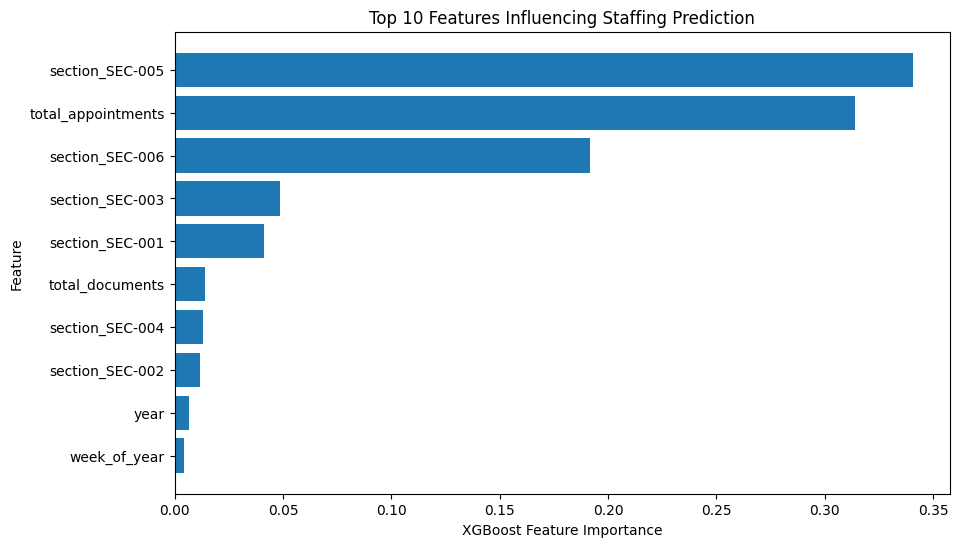

In [83]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


# Make predictions on the validation data
y_pred = model.predict(X_val)

# Calculate performance metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)

print(f"Model Performance on Validation Data:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- Feature Importance ---
# This tells us which features the model relied on the most
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n\nTop 10 Most Important Features:")
print(feature_importances.head(10))


# --- Plot Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'][:10], feature_importances['importance'][:10])
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Staffing Prediction')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()